In [1]:
import sys
import skimage.io as skio
import skimage as sk
import skimage.transform as transform
from skimage.measure import find_contours
import numpy as np
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if ros_path in sys.path:
    sys.path.remove(ros_path)
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')
import matplotlib.pyplot as plt

/Users/xavilla/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


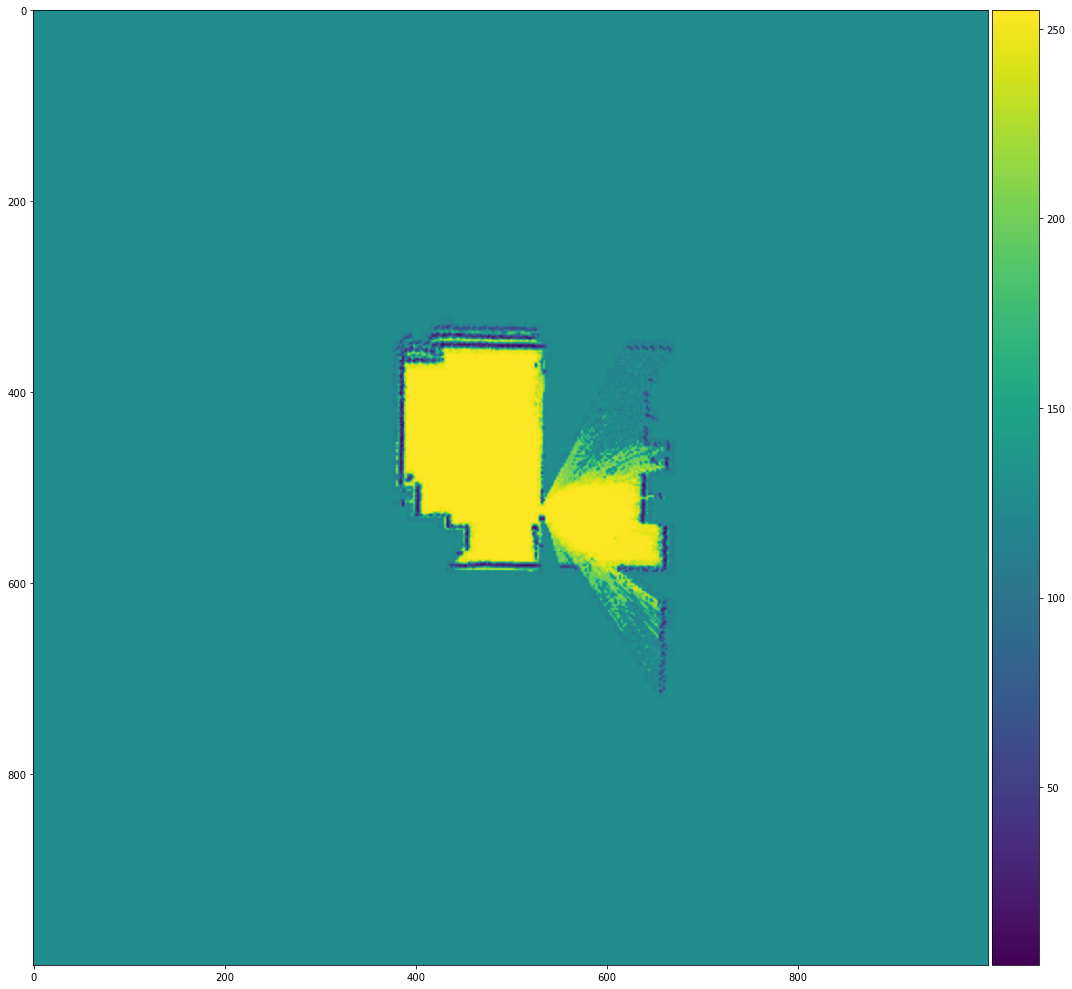

In [2]:
a = skio.imread("run1.jpg")
a = a[::-1]
size = a.shape
plt.figure(figsize = (15,15))
a = sk.measure.block_reduce(a, (2,2), np.min)
a = transform.resize(a, size, preserve_range=True)
skio.imshow(a)

/Users/xavilla/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


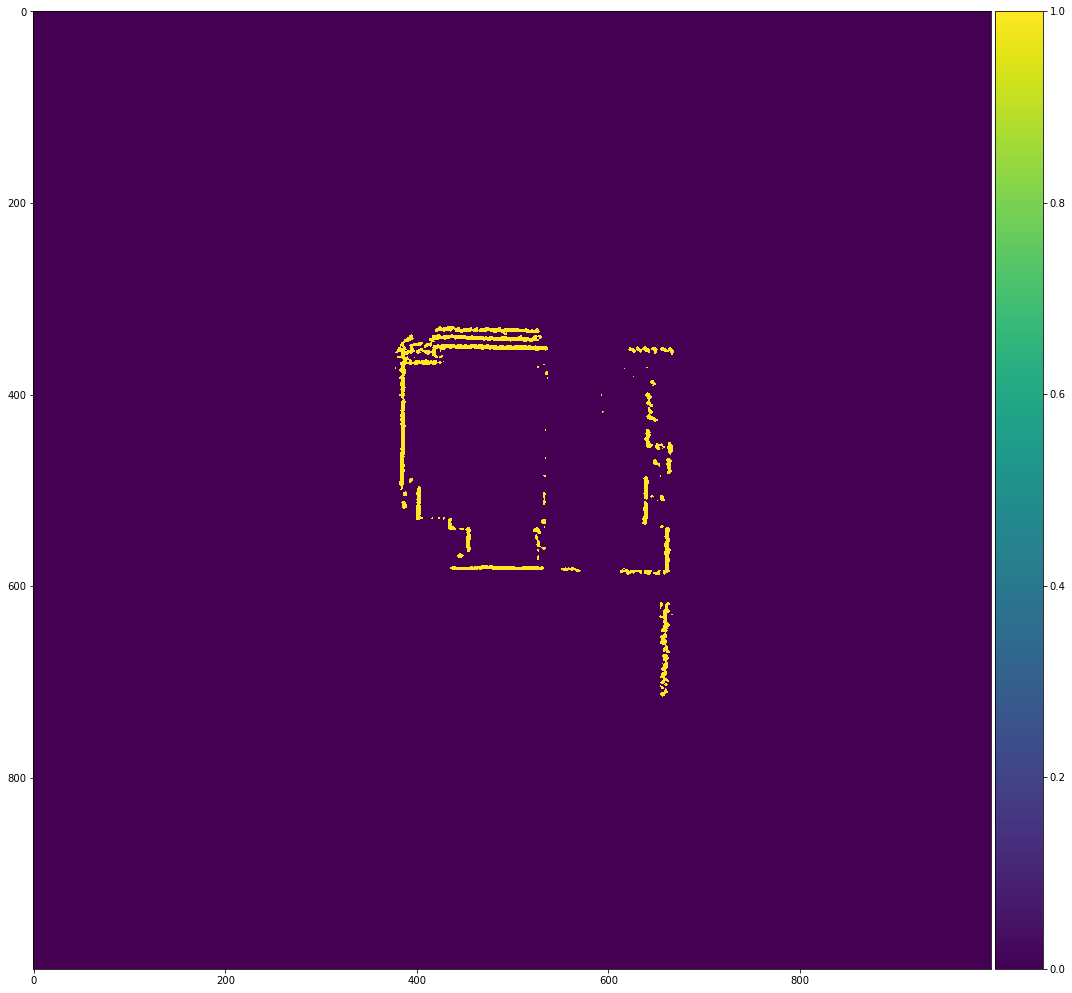

In [3]:
def obstacle_map(gridmap):
    copy = np.copy(gridmap)
    copy[copy == 127] = 255
    return copy < 105

def obstacle_indeices(obstacle_map):
    return np.nonzero(obstacle_map)

def show_obstacle(gridmap):
    black = np.zeros(gridmap.shape)
    black[obstacle_map(gridmap)] = 255
    return black
plt.figure(figsize = (15,15))
skio.imshow(obstacle_map(a))

In [4]:
# np.unique(a.reshape((40000, 1)))

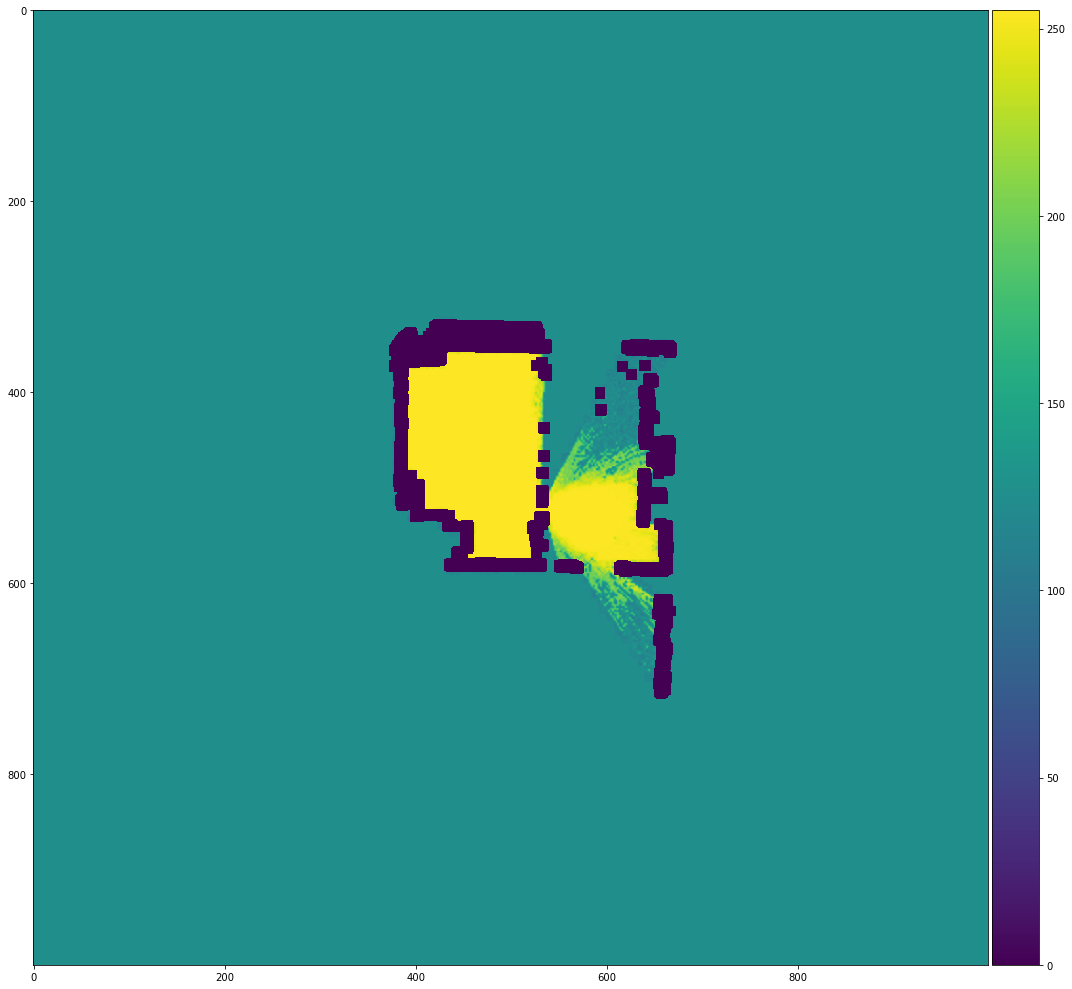

In [5]:
def grow_obstacle(gridmap):
    ob_map = obstacle_map(gridmap)
    copy = np.copy(gridmap)
    mask = np.copy(ob_map)
    step = 5
    for dx in range(-step, step+1):
        for dy in range(-step, step+1):
            roll = np.roll(np.roll(ob_map, dx, axis = 0), dy, axis = 1)
            mask = np.logical_or(roll, mask)
    copy[mask] = 0
            
    return copy
plt.figure(figsize=(15,15))
skio.imshow(grow_obstacle(a))

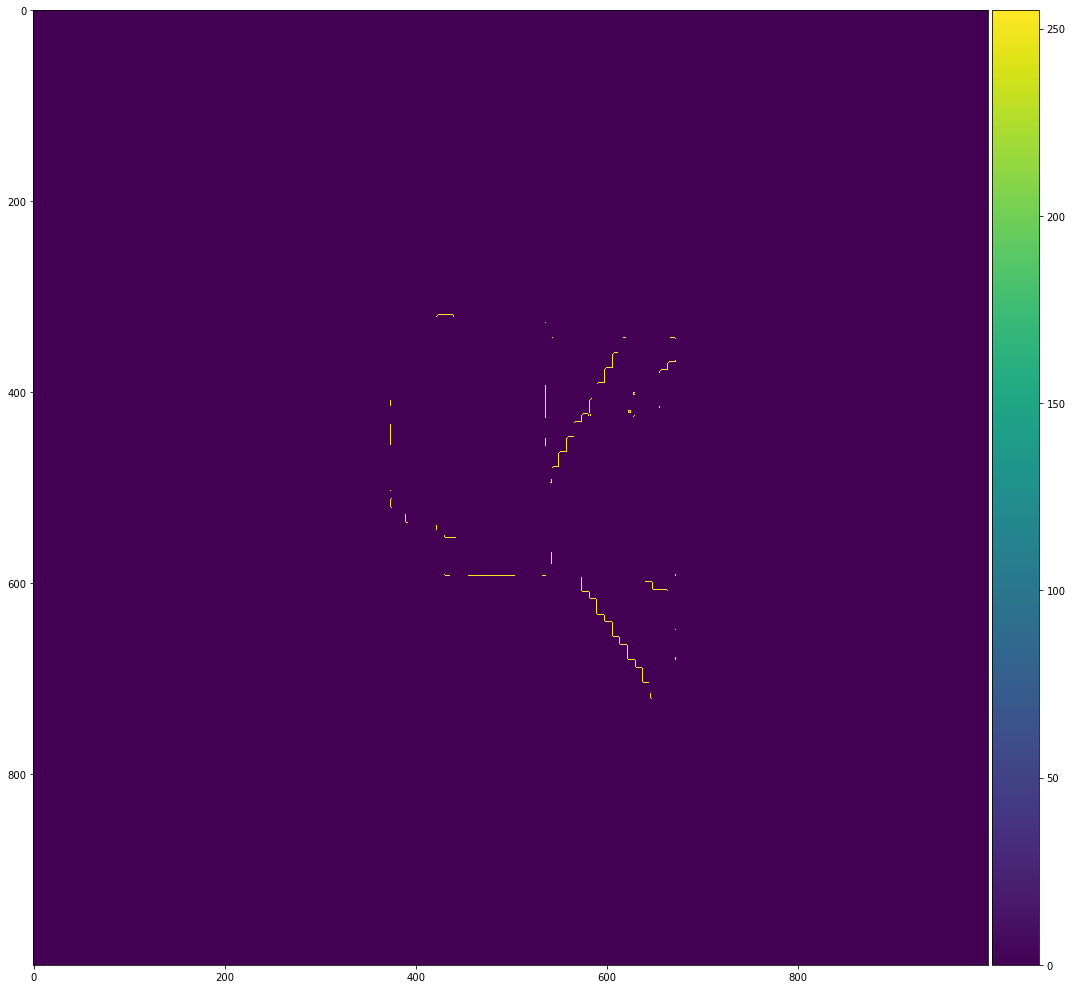

In [6]:
def frontier(gridmap):
    growed = grow_obstacle(gridmap)
    gray = growed == 127
    black = growed ==0
    white = np.logical_not(np.logical_or(gray, black))
    level_map = white*255+gray*127
    canny = cv2.Canny(level_map.astype(np.uint8), 1, 1)
    
    xs, ys = np.nonzero(canny)
    trued = np.copy(canny)
    for i in range(len(xs)):
        x, y = xs[i], ys[i]
        if x > 0 and x< gridmap.shape[0]:
            if y > 0 and y< gridmap.shape[1]:
                blackarea = black[x-4:x+5,y-4:y+5]
                blackave = np.mean(blackarea)
                
                whitearea = white[x-2:x+3,y-2:y+3]
                whiteave = np.mean(whitearea)
                if not blackave <0.1:
                    trued[x][y] = 0
                if not whiteave > 0.3:
                    trued[x][y] = 0
                
    return trued
plt.figure(figsize=(15, 15))
skio.imshow(frontier(a))

No handles with labels found to put in legend.


[20, 21, 22, 23, 24, 30, 160, 163, 370, 427, 428, 429, 430, 431, 541, 584, 586, 594]


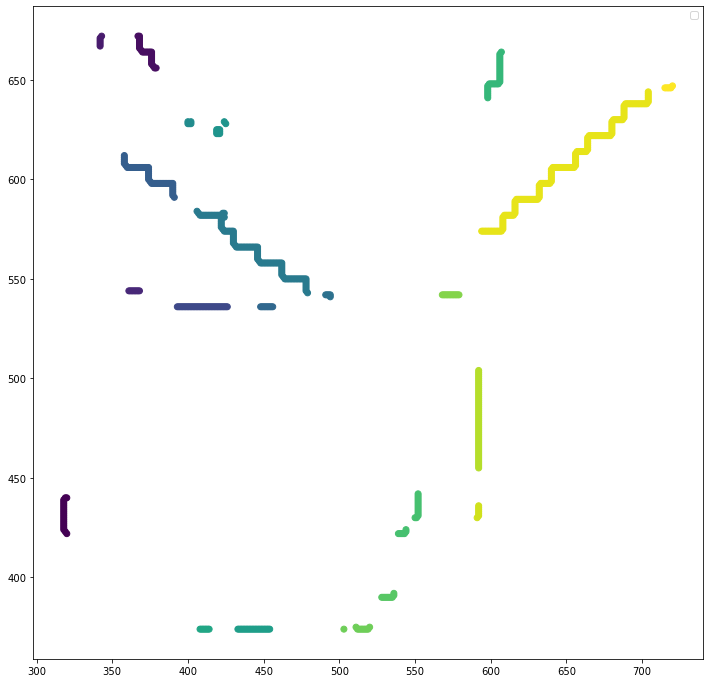

In [7]:
import scipy.cluster.hierarchy as hcluster
fro = frontier(a)
cordinates = np.array(np.nonzero(fro))

cordinates = np.transpose(cordinates)
clusters = hcluster.fclusterdata(cordinates, 10, criterion="distance")

group_id, group_count = np.unique(clusters, return_counts=True)
for i in group_id:
    if group_count[i - 1] < 5:
        clusters[clusters == i] = -5

filter_lst = []
for i in range(len(clusters)):
    if clusters[i] == -5:
        filter_lst.append(i)

clusters = np.delete(clusters, filter_lst)
cordinates = np.delete(cordinates, filter_lst, axis=0)
cx, cy = np.transpose(cordinates)
print(filter_lst)

plt.figure(figsize=(12, 12))
plt.scatter(*np.transpose(cordinates), c=clusters)
plt.legend()

25
False
664.0


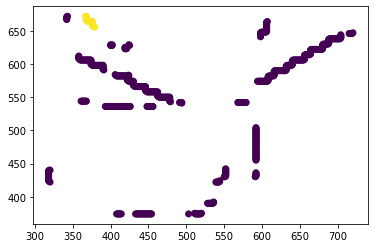

In [8]:
ccopy = np.copy(clusters)
ccopy[ccopy != 2] = 0
ones = np.nonzero(ccopy)
print(ones[0].size)
print(np.mean(cx[ones]) == np.nan)
print(np.mean(cy[ones]))
plt.scatter(*np.transpose(cordinates), c=ccopy)

In [9]:
sys.path.append('/home/daly/vrep_ws/slam-master-jason')
from lib.frontier import *

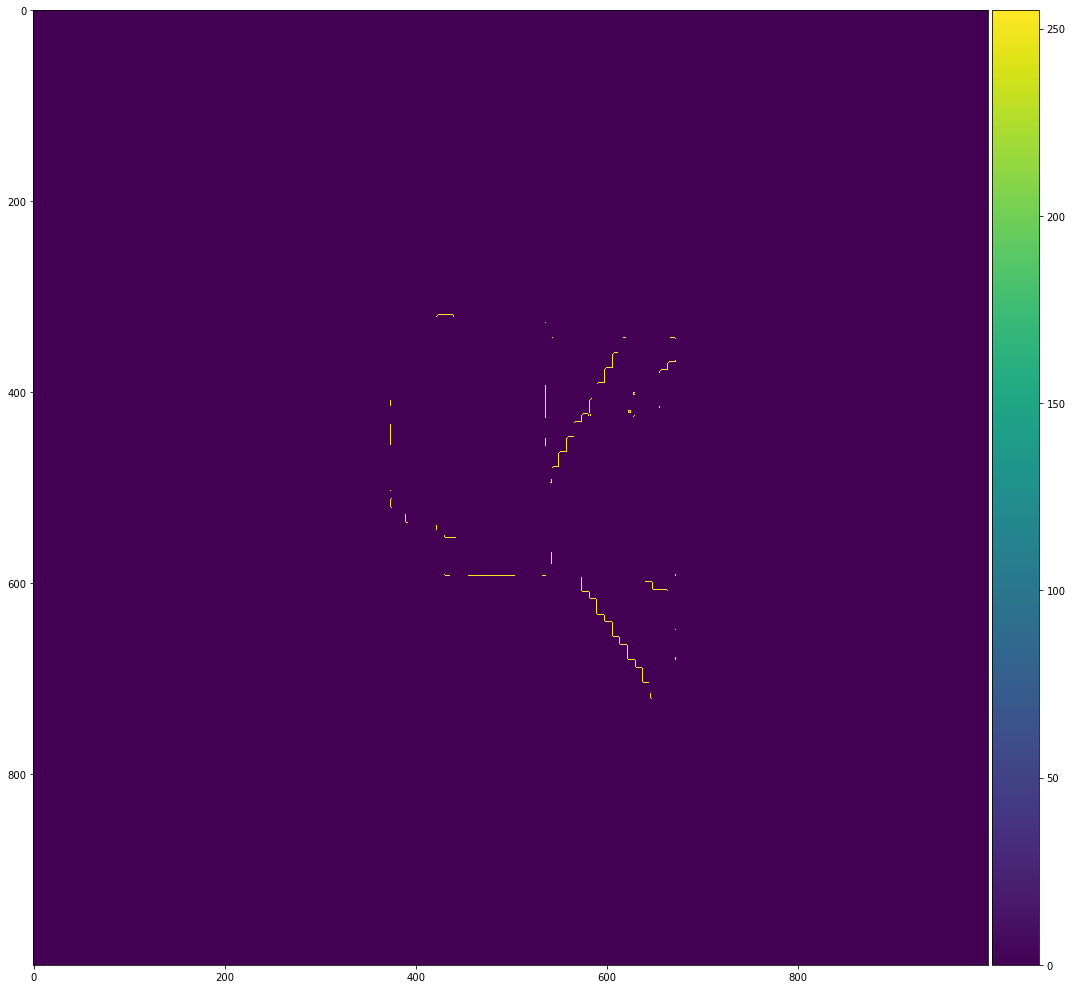

In [10]:
b = skio.imread("run1.jpg")
b = b[::-1]
#testx, testy, cl = frontier_cluster(b)
plt.figure(figsize=(15, 15))
#b = sk.measure.block_reduce(a, (2,2), np.min)
#b = transform.resize(a, size, preserve_range=True)
b = preprocess_grid(b)
skio.imshow(frontier(b))

In [11]:
from lib.pathplanner import lee_planning_path

[[ 10  20  30   0 100]
 [  0  10  40  50  10]
 [  0  20  50   0 100]
 [ 10  50  60  70  80]]
[(0, 2), (1, 2), (1, 4), (3, 4)]


In [12]:
def color_wp(grid, wp, c):
    for i in range(wp[0]-15, wp[0]+15):
        grid[i][wp[1]] = c
    for i in range(wp[1]-15, wp[1]+15):
        grid[wp[0]][i] = c
    return grid

a = skio.imread("run1.jpg")
a = a[::-1]
b = a.copy()
size = b.shape
b = sk.measure.block_reduce(a, (2,2), np.min)
b = transform.resize(b, size, preserve_range=True)
obst_b = grow_obstacle(b)
double_obst_b = grow_obstacle(obst_b)
import time
tstart = time.time()
wps = lee_planning_path(double_obst_b, (650, 450), (400, 750))
tend = time.time()
print(tend - tstart)
obst_b = color_wp(obst_b, (650, 450), 0.6)
obst_b = color_wp(obst_b, (400, 750), 0.8)
for wp in wps:
    obst_b = color_wp(obst_b, wp, 0.8)
plt.figure(figsize=(15, 15))
skio.imshow(obst_b)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 1000

In [ ]:
a = np.array([[10, 20, 30, 0, 100],
              [0, 10, 40, 50, 10],
              [0, 20, 50, 0, 100],
              [10, 50, 60, 70, 80]])
status = np.zeros((len(a), len(a[0])))
can_visit = np.ones((len(a), len(a[0])))
start, end = (0, 0), (3, 4)

In [ ]:
a = np.array([[10, 20, 30, 0, 100],
              [0, 10, 40, 50, 10],
              [0, 20, 50, 0, 100],
              [10, 50, 60, 70, 80]])
status = np.zeros((len(a), len(a[0])))
can_visit = np.ones((len(a), len(a[0])))
start, end = (0, 0), (3, 4)

reached = False
status[a < 10] = -1 #set obstacles to -1
can_visit[a < 10] = 0
status[start] = 1
can_visit[start] = 0
current_step = 1
while not reached:
    current_step_map = status == current_step
    rollup = np.roll(current_step_map, -1, axis = 0)
    rollup[-1] = False
    rollup = np.logical_and(rollup, can_visit)
    
    rolldown = np.roll(current_step_map, 1, axis = 0)
    rolldown[0] = False
    rolldown = np.logical_and(rolldown, can_visit)
    
    rollright = np.roll(current_step_map, 1, axis = 1)
    rollright[:, 0] = False
    rollright = np.logical_and(rollright, can_visit)
    
    rollleft = np.roll(current_step_map, -1, axis = 1)
    rollleft[:, -1] = False
    rollleft = np.logical_and(rollleft, can_visit)
    
    this_step = np.logical_or(np.logical_or(rollup, rolldown), np.logical_or(rollright, rollleft))
    assert(not np.sum(np.logical_and(this_step, np.logical_not(can_visit))))
    
    can_visit = np.logical_and(np.logical_not(this_step), can_visit)
    
    status[this_step] = current_step+1
    current_step+=1
    
    coordinates = np.transpose(np.nonzero(this_step))
    reached = list(end) in coordinates.tolist()

In [13]:
def lee(grid, start, end):
    status = np.zeros((len(a), len(grid[0])))
    can_visit = np.ones((len(a), len(grid[0])))
    visited = np.zeros((len(a), len(grid[0])))

    reached = False
    status[grid < 10] = -1 #set obstacles to -1
    can_visit[grid < 10] = 0
    status[start] = 1
    can_visit[start] = 0
    current_step = 1
    visited[start] = 1
    while not reached:
        current_step_map = status == current_step
        rollup = np.roll(current_step_map, -1, axis = 0)
        rollup[-1] = False
        rollup = np.logical_and(rollup, can_visit)

        rolldown = np.roll(current_step_map, 1, axis = 0)
        rolldown[0] = False
        rolldown = np.logical_and(rolldown, can_visit)

        rollright = np.roll(current_step_map, 1, axis = 1)
        rollright[:, 0] = False
        rollright = np.logical_and(rollright, can_visit)

        rollleft = np.roll(current_step_map, -1, axis = 1)
        rollleft[:, -1] = False
        rollleft = np.logical_and(rollleft, can_visit)

        this_step = np.logical_or(np.logical_or(rollup, rolldown), np.logical_or(rollright, rollleft))
        assert(not np.sum(np.logical_and(this_step, np.logical_not(can_visit))))

        can_visit = np.logical_and(np.logical_not(this_step), can_visit)
        visited = np.logical_or(this_step, visited)

        status[this_step] = current_step+1
        current_step+=1

        coordinates = np.transpose(np.nonzero(this_step))
        reached = list(end) in coordinates.tolist()
        
        
    if status[end[0]][end[1]] == 0 and start != end:
        print("not accessible")
        return [] #end is not accessible
    
    paths = []
    paths.append([0, np.array([end])])
    while True:
        
        
#         i, j = path[0]
#         if (i, j) == start:
#             break
#         min_val = 999
#         min_xy = (0, 0)
#         left = (i-1) >= 0 and status[i-1][j] != -1 and visited[i-1][j] == 1
#         right = (i+1) < len(grid) and status[i+1][j] != -1 and visited[i+1][j] == 1
#         top  = (j-1) >= 0 and status[i][j-1] != -1 and visited[i][j-1] == 1
#         bottom = (j+1) < len(grid[0]) and status[i][j+1] != -1 and visited[i][j+1] == 1
#         if left:
#             if status[i-1][j] < min_val:
#                 min_val = status[i-1][j]
#                 min_xy = (i-1, j)
#         if right:
#             if status[i+1][j] < min_val:
#                 min_val = status[i+1][j]
#                 min_xy = (i+1, j)
#         if top:
#             if status[i][j-1] < min_val:
#                 min_val = status[i][j-1]
#                 min_xy = (i, j-1)
#         if bottom:
#             if status[i][j+1] < min_val:
#                 min_val = status[i][j+1]
#                 min_xy = (i, j+1)
#         path.insert(0, min_xy)
    
    waypoints = find_waypoints(path)
    print(waypoints)
    return waypoints
        
def find_waypoints(path):
    waypoints = []
    for idx, pt in enumerate(path):
        if idx == 0:
            continue
        if idx == len(path) - 1:
            waypoints.append(pt)
            break
        diff = np.array(path[idx + 1]) - np.array(path[idx - 1])
        if (np.abs(diff) == np.array([1, 1])).all():
            waypoints.append(pt)
    return waypoints

IndentationError: expected an indented block (<ipython-input-13-417f4a9d9815>, line 80)

In [117]:
lee(a, (0, 0), (3, 4))

[(0, 2), (1, 2), (1, 4), (3, 4)]


[(0, 2), (1, 2), (1, 4), (3, 4)]

In [107]:
can_visit

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [108]:
this_step

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False,  True]])

In [102]:
coordinates

array([[0, 1]])